# EDA

In [83]:
# # Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install scipy

In [82]:
import os
import json
import pprint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

##### read in data for 2020-21 regular season


In [3]:
# year = '2020'
years = ['2015','2016','2017','2018','2019','2020']
games = {}
for year in years:
    path = os.getcwd()
    path = os.path.abspath(os.path.join(path, os.pardir, 'data/' + year + '_regSeasonPlays.json'))
    print(path)
    with open(path) as f:
        games[year] = json.load(f)

/Users/williamshaw/Projects/NHL/nhl_overtime_eda/data/2015_regSeasonPlays.json
/Users/williamshaw/Projects/NHL/nhl_overtime_eda/data/2016_regSeasonPlays.json
/Users/williamshaw/Projects/NHL/nhl_overtime_eda/data/2017_regSeasonPlays.json
/Users/williamshaw/Projects/NHL/nhl_overtime_eda/data/2018_regSeasonPlays.json
/Users/williamshaw/Projects/NHL/nhl_overtime_eda/data/2019_regSeasonPlays.json
/Users/williamshaw/Projects/NHL/nhl_overtime_eda/data/2020_regSeasonPlays.json


##### get a list of all faceoffs that happen in overtime, and the player/team that won those faceoffs

In [4]:
overtime_faceoffs = []

record = {}
record['game_id'] = ''
record['faceoff_win_player'] = ''
record['faceoff_win_team'] = ''
record['faceoff_lose_player'] = ''
record['faceoff_number'] = 0

for year in games:
    for game_id, game in games[year].items():
        record['game_id'] = game_id
        faceoff_number = 1
        for event in game['events']:
            if event['about']['periodType'] == 'OVERTIME' and event['result']['eventTypeId'] == 'FACEOFF':

                ## which player won/lost this faceoff #
                for player in event['players']:
                    if player['playerType'] == 'Winner':
                        record['faceoff_win_player'] = player['player']['fullName']
                    else:
                        record['faceoff_lose_player'] = player['player']['fullName']

                ## the team of the player who won this faceoff ##
                record['faceoff_win_team'] = event['team']['name']

                ## the number of faceoffs seen in this overtime so far ##
                record['faceoff_number'] = faceoff_number
                faceoff_number += 1

                overtime_faceoffs.append(record.copy())


##### get a list of the winning team for each game ending in overtime

In [5]:
game_results = []

record = {}
record['game_id'] = ''
record['home_team'] = ''
record['away_team'] = ''
record['home_goals'] = ''
record['away_goals'] = ''
record['winning_team'] = ''
record['losing_team'] = ''
record['last_period'] = ''

for year in games:
    for game_id, game in games[year].items():
        ## game_id and home/away team names ##
        record['game_id'] = game_id
        record['home_team'] = game['home_team']
        record['away_team'] = game['away_team']

        ## get goals for each team ##
        for event in game['events']:
            if event['result']['eventTypeId'] == 'GAME_END':
                record['home_goals'] = event['about']['goals']['home']
                record['away_goals'] = event['about']['goals']['away']
                record['last_period'] = event['about']['periodType']

        ## calculate which team won/lost the game based on number of goals ##
        if record['home_goals'] > record['away_goals']:
            record['winning_team'] = record['home_team']
            record['losing_team'] = record['away_team']
        else:
            record['winning_team'] = record['away_team']
            record['losing_team'] = record['home_team']

        game_results.append(record.copy())


##### convert to pandas dataframe

In [6]:
# faceoff data
df_fo = pd.DataFrame.from_dict(overtime_faceoffs)
display(df_fo.head())

# game results data
df_winloss = pd.DataFrame.from_dict(game_results)
display(df_winloss.head())
display(df_winloss['last_period'].value_counts())

,game_id,faceoff_win_player,faceoff_win_team,faceoff_lose_player,faceoff_number
0,2015020007,Valtteri Filppula,Tampa Bay Lightning,Claude Giroux,1
1,2015020007,Sean Couturier,Philadelphia Flyers,Steven Stamkos,2
2,2015020007,Valtteri Filppula,Tampa Bay Lightning,Claude Giroux,3
3,2015020015,John Tavares,New York Islanders,Jonathan Toews,1
4,2015020015,Frans Nielsen,New York Islanders,Jonathan Toews,2


,game_id,home_team,away_team,home_goals,away_goals,winning_team,losing_team,last_period
0,2015020001,Toronto Maple Leafs,Montréal Canadiens,1,3,Montréal Canadiens,Toronto Maple Leafs,REGULAR
1,2015020002,Chicago Blackhawks,New York Rangers,2,3,New York Rangers,Chicago Blackhawks,REGULAR
2,2015020003,Calgary Flames,Vancouver Canucks,1,5,Vancouver Canucks,Calgary Flames,REGULAR
3,2015020004,Los Angeles Kings,San Jose Sharks,1,5,San Jose Sharks,Los Angeles Kings,REGULAR
4,2015020005,Boston Bruins,Winnipeg Jets,2,6,Winnipeg Jets,Boston Bruins,REGULAR


REGULAR     5563
OVERTIME    1028
SHOOTOUT     548
Name: last_period, dtype: int64

##### merge datasets on game_id

In [7]:
df = df_fo.merge(df_winloss[df_winloss['last_period']=='OVERTIME'], how='inner', on='game_id')
df.head()

,game_id,faceoff_win_player,faceoff_win_team,faceoff_lose_player,faceoff_number,home_team,away_team,home_goals,away_goals,winning_team,losing_team,last_period
0,2015020007,Valtteri Filppula,Tampa Bay Lightning,Claude Giroux,1,Tampa Bay Lightning,Philadelphia Flyers,3,2,Tampa Bay Lightning,Philadelphia Flyers,OVERTIME
1,2015020007,Sean Couturier,Philadelphia Flyers,Steven Stamkos,2,Tampa Bay Lightning,Philadelphia Flyers,3,2,Tampa Bay Lightning,Philadelphia Flyers,OVERTIME
2,2015020007,Valtteri Filppula,Tampa Bay Lightning,Claude Giroux,3,Tampa Bay Lightning,Philadelphia Flyers,3,2,Tampa Bay Lightning,Philadelphia Flyers,OVERTIME
3,2015020015,John Tavares,New York Islanders,Jonathan Toews,1,New York Islanders,Chicago Blackhawks,2,3,Chicago Blackhawks,New York Islanders,OVERTIME
4,2015020015,Frans Nielsen,New York Islanders,Jonathan Toews,2,New York Islanders,Chicago Blackhawks,2,3,Chicago Blackhawks,New York Islanders,OVERTIME


##### extract features

In [8]:
# interested in how much predictive power the result of the opening faceoff can be, in games the end in overtime
conditions = [df['faceoff_win_team'] == df['winning_team'],]
choices = [1,]

df['faceoffWon_gameWon'] = np.select(conditions, choices, default=0)

In [9]:
df[df['faceoff_number']==1][['game_id','faceoff_win_team','winning_team','last_period','faceoffWon_gameWon']]

,game_id,faceoff_win_team,winning_team,last_period,faceoffWon_gameWon
0,2015020007,Tampa Bay Lightning,Tampa Bay Lightning,OVERTIME,1
3,2015020015,New York Islanders,Chicago Blackhawks,OVERTIME,0
5,2015020028,Vancouver Canucks,Calgary Flames,OVERTIME,0
8,2015020064,Minnesota Wild,Los Angeles Kings,OVERTIME,0
10,2015020075,New York Rangers,New Jersey Devils,OVERTIME,0
...,...,...,...,...,...
2158,2020020856,Washington Capitals,Washington Capitals,OVERTIME,1
2162,2020020859,Columbus Blue Jackets,Columbus Blue Jackets,OVERTIME,1
2170,2020020860,Chicago Blackhawks,Dallas Stars,OVERTIME,0
2175,2020020865,Minnesota Wild,Minnesota Wild,OVERTIME,1


##### calculate percentage of teams that won after winning first faceoff

array([[<AxesSubplot:title={'center':'faceoffWon_gameWon'}>]],
      dtype=object)

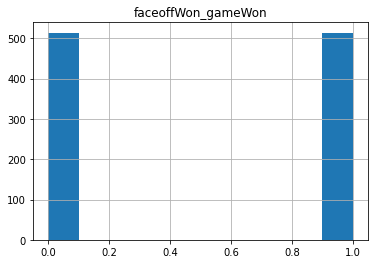

In [10]:
df[df['faceoff_number']==1].hist('faceoffWon_gameWon')

In [11]:
df[df['faceoff_number']==1]['faceoffWon_gameWon'].value_counts()
# df_winloss['last_period'].value_counts()

1    514
0    513
Name: faceoffWon_gameWon, dtype: int64

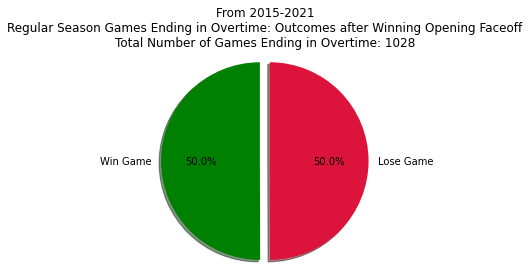

<Figure size 432x288 with 0 Axes>

In [12]:
# calculate total overtime games
ot_games = df_winloss['last_period'].value_counts()[1]
    
# get counts for game outcomes when the first faceoff of an overtime is won
games_won = df[df['faceoff_number']==1]['faceoffWon_gameWon'].value_counts()[1]
games_lost = df[df['faceoff_number']==1]['faceoffWon_gameWon'].value_counts()[0]

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Win Game', 'Lose Game'
sizes = [games_won, games_lost]
explode = (0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90,
        colors=['g', 'crimson'])
ax1.set_title('From 2015-2021\nRegular Season Games Ending in Overtime: Outcomes after Winning Opening Faceoff\n' + \
                  'Total Number of Games Ending in Overtime: ' + str(ot_games))
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
plt.tight_layout()
fig1.savefig('images/outcomes_allszns.png', bbox_inches="tight", edgecolor='black')


##### Verify that we correctly assigned labels by checking the total number of games per season

In [13]:
def sum_array(a):
    total = 0
    for num in a:
        total += num
    return total

print('...verifying total games per season in correct')
for year in games:
    print(year + '-' + str(int(year)+1) + ' szn')
    print('total games: ' + str(sum_array(df_winloss[df_winloss['game_id'].str.startswith(year)]['last_period'].value_counts())))
    display(df_winloss[df_winloss['game_id'].str.startswith(year)]['last_period'].value_counts())
    
    

...verifying total games per season in correct
2015-2016 szn
total games: 1229


REGULAR     954
OVERTIME    168
SHOOTOUT    107
Name: last_period, dtype: int64

2016-2017 szn
total games: 1229


REGULAR     940
OVERTIME    190
SHOOTOUT     99
Name: last_period, dtype: int64

2017-2018 szn
total games: 1271


REGULAR     976
OVERTIME    192
SHOOTOUT    103
Name: last_period, dtype: int64

2018-2019 szn
total games: 1271


REGULAR     999
OVERTIME    184
SHOOTOUT     88
Name: last_period, dtype: int64

2019-2020 szn
total games: 1271


REGULAR     1021
OVERTIME     164
SHOOTOUT      86
Name: last_period, dtype: int64

2020-2021 szn
total games: 868


REGULAR     673
OVERTIME    130
SHOOTOUT     65
Name: last_period, dtype: int64

##### calculate percentage of teams that won after winning first faceoff BY SEASON

2015
76
92
Total Number of Games Ending in Overtime: 168


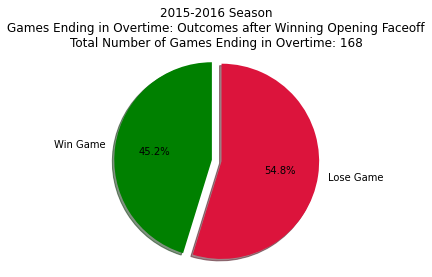

2016
101
89
Total Number of Games Ending in Overtime: 190


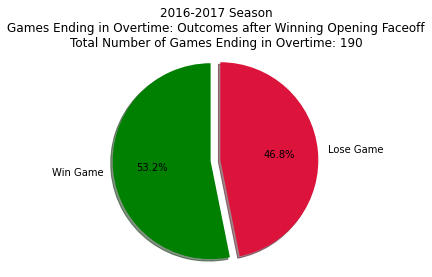

2017
93
99
Total Number of Games Ending in Overtime: 192


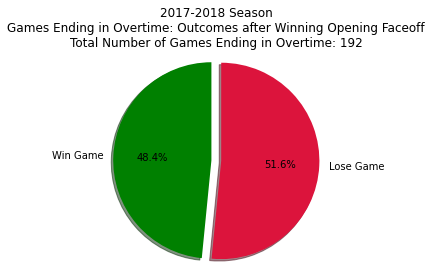

2018
81
103
Total Number of Games Ending in Overtime: 184


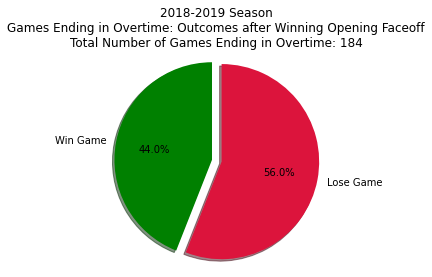

2019
90
74
Total Number of Games Ending in Overtime: 164


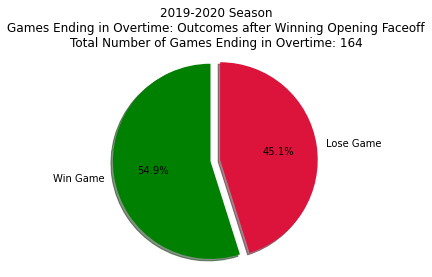

2020
73
56
Total Number of Games Ending in Overtime: 130


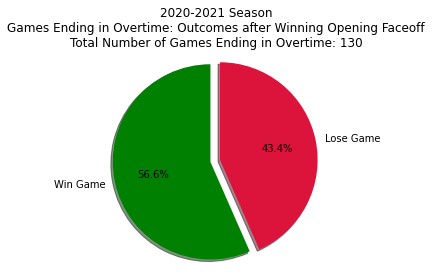

In [14]:
openfaceoff_win_pct = []
for year in games:
    print(year)
    print(df[(df['faceoff_number']==1) & (df['game_id'].str.startswith(year))]['faceoffWon_gameWon'].value_counts()[1])
    print(df[(df['faceoff_number']==1) & (df['game_id'].str.startswith(year))]['faceoffWon_gameWon'].value_counts()[0])
    
    # calculate total overtime games
    ot_games = df_winloss[df_winloss['game_id'].str.startswith(year)]['last_period'].value_counts()[1]
    print('Total Number of Games Ending in Overtime: ' + str(ot_games))
    
    # get counts for game outcomes when the second faceoff of an overtime is won
    games_won = df[df['faceoff_number']==1 & (df['game_id'].str.startswith(year))]['faceoffWon_gameWon'].value_counts()[1]
    games_lost = df[df['faceoff_number']==1 & (df['game_id'].str.startswith(year))]['faceoffWon_gameWon'].value_counts()[0]
    openfaceoff_win_pct.append(games_won / (games_won + games_lost))
    
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = 'Win Game', 'Lose Game'
    sizes = [games_won, games_lost]
    explode = (0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90,
            colors=['g', 'crimson'])
    ax1.set_title(year + '-' + str(int(year)+1) + ' Season\n' + \
                  'Games Ending in Overtime: Outcomes after Winning Opening Faceoff\n' + \
                  'Total Number of Games Ending in Overtime: ' + str(ot_games))
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()
    
    # save figure to storage
    fname = 'images/outcomes_' + year + '.png'
    fig1.savefig(fname, bbox_inches="tight")


##### create bar chart to represent how the outcome of opening faceoff has changed

In [15]:
years_adj = []
for year in years:
    years_adj.append(year + '-' + str(int(year)+1))

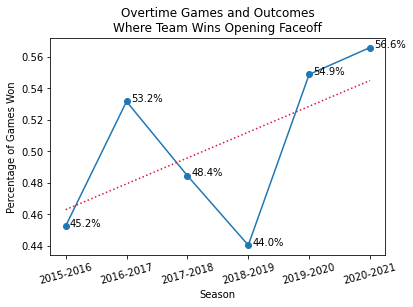

In [79]:
# create figure
fig1, ax1 = plt.subplots()

# plot data
plt.plot(years_adj, openfaceoff_win_pct, marker='o')

# add title and axis names
plt.title('Overtime Games and Outcomes\nWhere Team Wins Opening Faceoff')
plt.xlabel('Season')
plt.ylabel('Percentage of Games Won')

# add labels to each point
for x, y in zip(years_adj, openfaceoff_win_pct):
    label = str(round(y*100,1))+'%'
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(20,0), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

# adjust ticks rotation
plt.xticks(rotation=15)

# add trendline
x = list(range(0,len(years_adj)))
z = np.polyfit(x, openfaceoff_win_pct, 1)
p = np.poly1d(z)
plt.plot(x,p(x),linestyle=':', color='crimson')

plt.show()

# save figure to storage
fname = 'images/outcomes_trends.png'
fig1.savefig(fname, bbox_inches="tight")

##### Test of significance for 2019-20 season rates
Testing if the rate of winning overtime games is random in regards to winning the opening faceoff:

$$
H_0: \pi = 0.5\\
H_a: \pi \neq 0.5\\
\alpha = 0.05
$$

Where:

$$
x = 90 \hspace{1pt} (successes)\\
n = 164 \hspace{1pt} (total \hspace{1pt} trials)\\
$$

Results of 1-Sided Binomial Test:

$$
p = binom(x=90,n=164,p=0.5) \\
p = 0.12
$$

Conclusion:
$$
\text{Since } p \not \lt \alpha \text{, we cannot reject } H_0\text{. During the 2019-20 season,} \\ 
\text{there is not enough evidence to say the rate of overtime wins significantly differs when a team wins the opening faceoff.} 
$$

In [95]:
display(df[(df['faceoff_number']==1) & (df['game_id'].str.startswith('2019'))]['faceoffWon_gameWon'].value_counts())
print('total games: ' + str(sum_array(df[(df['faceoff_number']==1) & (df['game_id'].str.startswith('2019'))]['faceoffWon_gameWon'].value_counts())))

stats.binom_test(90, n=164, p=0.5, alternative='greater')


1    90
0    74
Name: faceoffWon_gameWon, dtype: int64

total games: 164


0.1206947758281016

##### Test of significance for 2020-21 season rates
Testing if the rate of winning overtime games is random in regards to winning the opening faceoff:

$$
H_0: \pi = 0.5\\
H_a: \pi \neq 0.5\\
\alpha = 0.05
$$

Where:

$$
x = 73 \hspace{1pt} (successes)\\
n = 129 \hspace{1pt} (total \hspace{1pt} trials)\\
$$

Results of 1-Sided Binomial Test:

$$
p = binom(x=73,n=129,p=0.5) \\
p = 0.079
$$

Conclusion:
$$
\text{Since } p \not \lt \alpha \text{, we cannot reject } H_0\text{. During the 2020-21 season,} \\ 
\text{there is not enough evidence to say the rate of overtime wins significantly differs when a team wins the opening faceoff.} 
$$

In [94]:
display(df[(df['faceoff_number']==1) & (df['game_id'].str.startswith('2020'))]['faceoffWon_gameWon'].value_counts())
print('total games: ' + str(sum_array(df[(df['faceoff_number']==1) & (df['game_id'].str.startswith('2020'))]['faceoffWon_gameWon'].value_counts())))

stats.binom_test(73, n=129, p=0.5, alternative='greater')


1    73
0    56
Name: faceoffWon_gameWon, dtype: int64

total games: 129


0.07932685709616122

##### what is the faceoff percentage of the dallas stars in overtime (14 overtime losses in 2020-21)?

In [17]:
conditions = [df['winning_team'] == 'Dallas Stars',
              df['losing_team'] == 'Dallas Stars',
             ]
choices = [1,1]

df['dallas'] = np.select(conditions, choices, default=0)

In [18]:
df[(df['game_id'].str.contains('2020')) &(df['dallas']==1) & (df['faceoff_number']==1)][['faceoff_win_team', 'winning_team']]


,faceoff_win_team,winning_team
1269,Dallas Stars,Dallas Stars
1930,Florida Panthers,Florida Panthers
1959,Detroit Red Wings,Dallas Stars
1977,Dallas Stars,Chicago Blackhawks
1982,Dallas Stars,Chicago Blackhawks
2046,Columbus Blue Jackets,Columbus Blue Jackets
2078,Dallas Stars,Florida Panthers
2086,Nashville Predators,Nashville Predators
2110,Dallas Stars,Florida Panthers
2126,Detroit Red Wings,Dallas Stars


In [19]:
df[(df['game_id'].str.contains('2020')) &(df['dallas']==1) & (df['faceoff_number']==1)]['faceoffWon_gameWon'].value_counts()


0    7
1    6
Name: faceoffWon_gameWon, dtype: int64

In [20]:
print(games_won)
print(games_lost)

73
56
